In [1]:
import os
import time
import glob
import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as cm

from invisible_cities.cities.hypathia import hypathia
from invisible_cities.core            import system_of_units as units
from invisible_cities.core.configure  import configure
from invisible_cities.core.configure  import all             as all_events

from invisible_cities.database import load_db

In [2]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

In [3]:
inputfilename = os.path.expandvars("$LUSTRE/NEXT100/0nubb/detsim/prod/detsim/detsim_0_0nubb.h5")

In [4]:
pes = units.pes
mus = units.mus

conf = configure('hypathia $ICTDIR/invisible_cities/config/hypathia.conf'.split())

# config params
conf["files_in"]    = inputfilename
conf["file_out"]    = "test.h5"
conf["compression"] = 'ZLIB4'
conf["run_number"]  = 0
conf["detector_db"] = "next100"
conf["print_mod"]   = 1
# conf["event_range"] = all_events
conf["event_range"] = (0, 10)

conf["pmt_wfs_rebin"] = 1
conf["pmt_pe_rms"]    = 0.4
conf["sipm_noise_cut"] = 1.0 * pes
conf["filter_padding"] = 50

# Set thresholds for calibrated sum
conf["thr_csum_s1"] = 0.1 * pes
conf["thr_csum_s2"] = 0.1 * pes

# sipm thresholds
conf["thr_sipm"]      = 1.0 * pes
conf["thr_sipm_type"] = "common"
conf["thr_sipm_s2"]   = 1 * pes # Threshold for the full sipm waveform

# Set parameters to search for S1
conf["s1_tmin"]   =  10 * mus # position of S1 in MC files at 100 mus
conf["s1_tmax"]   =  12 * mus # change tmin and tmax if S1 not at 100 mus
conf["s1_stride"] =   4       # minimum number of 25 ns bins in S1 searches
conf["s1_lmin"]   =   4       # 8 x 25 = 200 ns
conf["s1_lmax"]   =  40       # 20 x 25 = 500 ns
conf["s1_rebin_stride"] = 1   # Do not rebin S1 by default

# Set parameters to search for S2
conf["s2_tmin"]   =    12 * mus  # assumes S1 at 100 mus, change if S1 not at 100 mus
conf["s2_tmax"]   =  1300 * mus  # end of the window
conf["s2_stride"] =     40       #  40 x 25 = 1   mus
conf["s2_lmin"]   =     20       # 100 x 25 = 2.5 mus
conf["s2_lmax"]   = 100000       # maximum value of S2 width
conf["s2_rebin_stride"]  = 40    # Rebin by default, 40 25 ns time bins to make one 1us time bin

In [5]:
t0 = time.time()

result = hypathia(**conf)

print("Exec (s)", time.time()-t0)

events processed: 0, event number: 0
events processed: 1, event number: 8
events processed: 2, event number: 16
events processed: 3, event number: 24
events processed: 4, event number: 32
events processed: 5, event number: 40
events processed: 6, event number: 48
events processed: 7, event number: 56
events processed: 8, event number: 64
events processed: 9, event number: 72
Exec (s) 13.13560700416565


In [6]:
S1   = pd.read_hdf(conf["file_out"], "PMAPS/S1")  .set_index("event")
S2   = pd.read_hdf(conf["file_out"], "PMAPS/S2")  .set_index("event")
S2Si = pd.read_hdf(conf["file_out"], "PMAPS/S2Si").set_index("event")

In [7]:
event_id = 56

with tb.open_file(inputfilename) as h5:
    event_ids = h5.root.Run.events.read()["evt_number"]
    idx = np.argwhere(event_ids == event_id).flatten()[0]
    
    pmtrd  = h5.root.pmtrd [idx]
    sipmrd = h5.root.sipmrd[idx]

In [8]:
s1 = S1.loc[event_id]
s2 = S2.loc[event_id]

pmtwf = np.sum(pmtrd, axis=0)
times = np.arange(0, len(pmtwf))*25

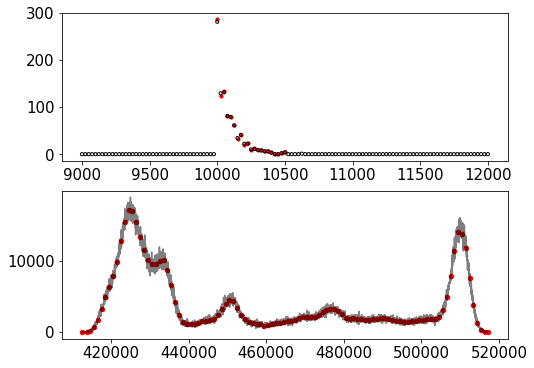

In [13]:
fig, (axs1, axs2) = plt.subplots(2, figsize=[8, 6])

# S1
axs1.scatter(s1["time"], s1["ene"], s=10, color="r")
sel = (conf["s1_tmin"]-1*mus <= times) & (times <= conf["s2_tmin"])
axs1.scatter(times[sel], pmtwf[sel], edgecolor="k", facecolor="none", s=10)

# S2
axs2.scatter(s2["time"], s2["ene"], s=20, color="r")
sel = (s2["time"].min()<= times) & (times<=s2["time"].max())
axs2.plot(times[sel], pmtwf[sel]*conf["s2_stride"], color="k", alpha=0.5);

In [14]:
datasipm = load_db.DataSiPM(conf["detector_db"], conf["run_number"])

charges = np.sum(sipmrd, axis=1)
s2si    = S2Si.loc[event_id].groupby("nsipm").ene.sum().to_frame()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd41c822bb0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd41c822bb0> on colorbar
Setting pcolormesh


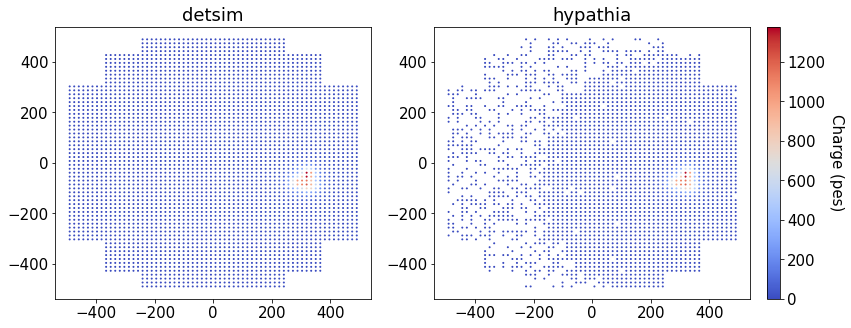

In [18]:
norm   = colors.Normalize(vmin=0, vmax=np.max((charges.max(), s2si["ene"].max())), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)


fig, (axdet, axhyp) = plt.subplots(1,2, figsize=[15, 5])
cbar = fig.colorbar(mapper, ax=(axdet, axhyp), pad=0.02)
cbar.ax.set_ylabel("Charge (pes)", rotation=-90, va="bottom")

#detsim
axdet.set_title("detsim")
axdet.scatter(datasipm["X"], datasipm["Y"], s=1, color=mapper.to_rgba(charges))

#hypathia
axhyp.set_title("hypathia")
axhyp.scatter(datasipm.loc[s2si.index]["X"], datasipm.loc[s2si.index]["Y"], s=1, color=mapper.to_rgba(s2si["ene"]))